### Assignment 2

**Analysis of Airbnb listings in Mallorca**

Goal:
- Your task will be to help a company operating small and mid-size apartments hosting 2-6 guests. 
- The company is set to price their new apartments not on the market.
- Build a price prediction model similarly to how we did in our case study for London.
- Discuss your modeling decisions and compare your results to those of the case study.

Getting the data:
- You may use other variables we used in class.
- You may do different feature engineering depending on the selected environment.
- You may make other sample design decisions!
- In each case, document your steps!
- Have at least 3 different models and compare performance
- Argue for your choice of models:
- One model must be theoretically profound linear regression via OLS.
- One model must be Random Forest or any boosting algorithm


Course: Data Analysis 3

Created by: Marcell Magda

Date: -

## Import Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import os
from pathlib import Path
import sys
from patsy import dmatrices
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import math

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import partial_dependence
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error

from collections import defaultdict
import ast  # To safely evaluate string literals as lists

## 1. Import data
IMPORTANT: Using listings from September as those have ammenities, the later ones don't.

In [2]:
# DATA IMPORT - FROM GITHUB
data = pd.read_csv('https://raw.githubusercontent.com/MarcellM01/Data-Analysis-3/main/Assignment_2/listings.csv')

In [3]:
data.head()

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,69998,https://www.airbnb.com/rooms/69998,20230911050559,2023-09-12,previous scrape,Loft in Palma de Mallorca · ★4.94 · 1 bedroom ...,Perfect place to escape for a few days of peac...,( soho-chic bohemian neighborhood of the city ...,https://a0.muscache.com/pictures/6d4007c1-f223...,353156,...,4.96,4.89,4.80,NaN,t,2,2,0,0,1.81
1,548218,https://www.airbnb.com/rooms/548218,20230911050559,2023-09-11,city scrape,Rental unit in Palma de Mallorca · ★4.73 · 2 b...,Este establecimiento de Turismo Interior está ...,NaN,https://a0.muscache.com/pictures/miso/Hosting-...,2694897,...,4.92,4.90,4.71,TI/90,f,5,5,0,0,3.60
2,106833,https://www.airbnb.com/rooms/106833,20230911050559,2023-09-11,city scrape,Villa in Sant Llorenç des Cardassar · ★4.94 · ...,<b>The space</b><br />This is a restored old b...,NaN,https://a0.muscache.com/pictures/miso/Hosting-...,551974,...,5.00,4.71,4.76,ET/1961,f,1,1,0,0,0.12
3,553166,https://www.airbnb.com/rooms/553166,20230911050559,2023-09-12,previous scrape,Cabin in Fornalutx · ★4.95 · 2 bedrooms · 2 be...,License nº ( 505/ 2015 ) / ET )<br />Prices ...,As you can read by other guests this is a uniq...,https://a0.muscache.com/pictures/6766065/d0ace...,2718219,...,4.97,4.91,4.82,505/2015/ET,f,1,1,0,0,1.03
4,159218,https://www.airbnb.com/rooms/159218,20230911050559,2023-09-11,city scrape,Cottage in Selva · ★4.91 · 1 bedroom · 2 beds ...,We are strong supporters of sustainable touris...,NaN,https://a0.muscache.com/pictures/22458820/5aad...,763897,...,4.94,4.80,4.75,ET-3025 Conselleria de Turismo de Baleares,f,1,1,0,0,2.34


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18832 entries, 0 to 18831
Data columns (total 75 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            18832 non-null  int64  
 1   listing_url                                   18832 non-null  object 
 2   scrape_id                                     18832 non-null  int64  
 3   last_scraped                                  18832 non-null  object 
 4   source                                        18832 non-null  object 
 5   name                                          18832 non-null  object 
 6   description                                   18660 non-null  object 
 7   neighborhood_overview                         7011 non-null   object 
 8   picture_url                                   18832 non-null  object 
 9   host_id                                       18832 non-null 

## 2. Cleaning Data

### 2.1 Create New Dataframe For Relevant Variables

In [5]:
import pandas as pd

def clean_airbnb_data(df):
    """
    Clean and preprocess the Airbnb dataset.
    Filter accommodations, clean price, filters property types, selected amenities.
    """
    # Keep listings accommodating 2 to 6 guests
    filtered_df = df[(df['accommodates'] >= 2) & (df['accommodates'] <= 6)]
    
    # Select relevant columns for modeling
    relevant_columns = [
        'accommodates', 'beds', 'review_scores_rating', 'host_is_superhost',
        'latitude', 'longitude', 'number_of_reviews',
        'availability_365', 'minimum_nights', 'maximum_nights',
        'property_type', 'room_type', 'price', 'amenities', 'neighbourhood_cleansed',
        'id'
    ]
    processed_df = filtered_df[relevant_columns].copy()
    
    # Price column cleanup
    processed_df['price'] = processed_df['price'].replace({'\$': '', ',': ''}, regex=True).astype(float)
    processed_df.dropna(subset=['price'], inplace=True)
    processed_df = processed_df[processed_df['price'] > 0]
    processed_df['price'] = processed_df['price'].astype(int)
    
    # Filter out rare property types
    property_counts = processed_df['property_type'].value_counts()
    common_properties = property_counts[property_counts >= 100].index
    processed_df = processed_df[processed_df['property_type'].isin(common_properties)]
    
    return processed_df

# Assuming 'data' is your DataFrame loaded previously
cleaned_data = clean_airbnb_data(data)


In [6]:
cleaned_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12226 entries, 1 to 18830
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   accommodates            12226 non-null  int64  
 1   beds                    12157 non-null  float64
 2   review_scores_rating    9354 non-null   float64
 3   host_is_superhost       12154 non-null  object 
 4   latitude                12226 non-null  float64
 5   longitude               12226 non-null  float64
 6   number_of_reviews       12226 non-null  int64  
 7   availability_365        12226 non-null  int64  
 8   minimum_nights          12226 non-null  int64  
 9   maximum_nights          12226 non-null  int64  
 10  property_type           12226 non-null  object 
 11  room_type               12226 non-null  object 
 12  price                   12226 non-null  int32  
 13  amenities               12226 non-null  object 
 14  neighbourhood_cleansed  12226 non-null  obj

## 3. Exploratory Data Analysis (EDA)

### 3.1 Describing all data columns

In [7]:
cleaned_data.describe()

,accommodates,beds,review_scores_rating,latitude,longitude,number_of_reviews,availability_365,minimum_nights,maximum_nights,price,id
count,12226.000000,12157.000000,9354.000000,12226.000000,12226.000000,12226.000000,12226.000000,12226.000000,12226.000000,12226.000000,1.222600e+04
mean,4.494111,3.382249,4.648576,39.665043,3.004983,20.552756,193.950679,4.321773,702.568542,253.615901,2.591599e+17
std,1.500813,1.483669,0.508628,0.171349,0.243130,43.111580,126.688208,10.723649,480.353550,741.806476,3.794609e+17
min,2.000000,1.000000,0.000000,39.302070,2.347260,0.000000,0.000000,1.000000,1.000000,10.000000,1.068330e+05
25%,4.000000,2.000000,4.520000,39.551578,2.846342,1.000000,76.000000,1.000000,200.000000,125.000000,2.254076e+07
50%,4.000000,3.000000,4.800000,39.687100,3.054715,6.000000,198.000000,3.000000,1125.000000,183.000000,4.449842e+07
75%,6.000000,4.000000,4.970000,39.823498,3.147353,21.000000,318.000000,5.000000,1125.000000,264.000000,6.688053e+17
max,6.000000,14.000000,5.000000,39.921540,3.471520,1172.000000,365.000000,365.000000,1125.000000,50000.000000,9.766218e+17


### 3.2 Checking relevant columns

#### 3.2.1 Checking price for outliers

In [8]:
cleaned_data.price.describe(percentiles = [0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99]).map('{:,.1f}'.format)

count    12,226.0
mean        253.6
std         741.8
min          10.0
1%           42.0
10%          87.0
25%         125.0
50%         183.0
75%         264.0
90%         374.0
99%       1,000.0
max      50,000.0
Name: price, dtype: object

#### 3.2.2 Normalize price by removing extreme outliers

In [9]:
# Dealing with extreme values, create a function to remove them
def remove_outliers(df, column):
    return df[((df[column] >= df[column].quantile(0.25) - 1.5 * 
                (df[column].quantile(0.75) - df[column].quantile(0.25))) &
               (df[column] <= df[column].quantile(0.75) + 1.5 * 
                (df[column].quantile(0.75) - df[column].quantile(0.25))))]

# Remove extreme values from 'price'
cleaned_data = remove_outliers(cleaned_data, 'price')

cleaned_data['price'].describe()

count    11624.000000
mean       193.496129
std         93.141411
min         10.000000
25%        123.000000
50%        177.500000
75%        250.000000
max        472.000000
Name: price, dtype: float64

#### 3.2.3 Checking room type

In [10]:
# Keeping "hotel rooms" as the client may wish to aquire a boutique hotel

cleaned_data.room_type.value_counts()

room_type
Entire home/apt    10574
Private room         997
Hotel room            53
Name: count, dtype: int64

#### 3.2.4 Checking property type

In [11]:
cleaned_data.property_type.value_counts()

property_type
Entire rental unit             3333
Entire home                    3099
Entire villa                   2542
Entire cottage                  553
Private room in rental unit     468
Entire condo                    429
Entire townhouse                278
Entire chalet                   238
Private room in home            215
Room in hotel                   191
Room in boutique hotel          176
Entire serviced apartment       102
Name: count, dtype: int64

#### 3.2.5 Checking neighbourhoods

In [12]:
cleaned_data.neighbourhood_cleansed.value_counts()

neighbourhood_cleansed
Pollença                      1819
Palma de Mallorca             1306
Alcúdia                       1214
Santanyí                       663
Santa Margalida                540
Manacor                        537
Llucmajor                      403
Felanitx                       401
Capdepera                      396
Sóller                         385
Calvià                         328
Campos                         299
Artà                           296
Muro                           216
Sant Llorenç des Cardassar     209
Son Servera                    201
Ses Salines                    184
Selva                          176
Sa Pobla                       158
Inca                           156
Andratx                        140
Campanet                       120
Búger                          101
Sineu                           83
Petra                           80
Ariany                          75
Maria de la Salut               70
Binissalem                      

#### 3.2.6 Checking number of reviews

In [13]:
cleaned_data.number_of_reviews.value_counts()

number_of_reviews
0      2556
1      1000
2       681
3       535
4       432
       ... 
136       1
241       1
240       1
161       1
351       1
Name: count, Length: 281, dtype: int64

### 3.3 Extract Relevant Amenities

In [14]:
# Check structure of amenities values
cleaned_data.amenities.value_counts()

amenities
["Iron", "High chair", "Wifi", "Children\u2019s books and toys", "Patio or balcony", "Hot water kettle", "BBQ grill", "Air conditioning", "Kitchen", "Crib", "Hair dryer", "Private entrance", "Free street parking", "Coffee maker", "Safe", "Pool", "Essentials", "Stove", "Heating", "Bed linens", "Freezer", "Microwave", "TV", "Dishes and silverware", "Toaster", "Free parking on premises", "Mountain view", "Refrigerator", "Elevator", "Pool table"]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         16
["Pool", "Freezer", "Microwave", "Essentials", "TV",

In [15]:
## EXTRACT NUMBERS OF DIFFERENT AMENITIES

# Initialize a defaultdict to count amenities
amenities_count = defaultdict(int)

# Sample data - replace with your actual DataFrame column
amenities_series = data['amenities']

for amenities_str in amenities_series:
    # Convert the string representation of a list to an actual list
    # using ast.literal_eval for safely evaluating the string
    try:
        amenities_list = ast.literal_eval(amenities_str)
    except ValueError:
        # Skip rows where conversion fails
        continue
    
    # Update the count for each amenity
    for amenity in amenities_list:
        amenities_count[amenity] += 1

# Convert the defaultdict to a regular dict for easier handling
amenities_count = dict(amenities_count)

# Sort the amenities by count, descending
sorted_amenities = sorted(amenities_count.items(), key=lambda x: x[1], reverse=True)

# Display the sorted list of amenities and their counts
for amenity, count in sorted_amenities:
    print(f"{amenity}: {count}")

Kitchen: 17673
Wifi: 17570
Essentials: 15591
Hair dryer: 15408
Dishes and silverware: 14532
Iron: 14262
Refrigerator: 13809
Microwave: 13623
Bed linens: 13604
Washer: 12839
TV: 12063
Coffee maker: 11895
Oven: 11863
Hangers: 11802
Cooking basics: 11638
Dishwasher: 11580
Air conditioning: 11218
Hot water: 10469
BBQ grill: 10268
Free parking on premises: 9955
High chair: 9879
Heating: 9667
Private entrance: 9321
Crib: 9285
Freezer: 8824
Stove: 8266
First aid kit: 8090
Free street parking: 7712
Toaster: 7611
Hot water kettle: 7266
Fire extinguisher: 7119
Patio or balcony: 7058
Bathtub: 6952
Backyard: 6928
Outdoor furniture: 6634
Pool: 6542
Dedicated workspace: 6519
Self check-in: 6360
Outdoor dining area: 5862
Dining table: 5544
Long term stays allowed: 5519
Extra pillows and blankets: 5224
Private patio or balcony: 5170
Lockbox: 5130
Wine glasses: 4872
Drying rack for clothing: 4759
Room-darkening shades: 4738
Smoke alarm: 4700
Indoor fireplace: 4592
Mountain view: 4239
Shampoo: 4227
Gard

### 3.4 CREATE DUMMY VARIABLES

In [16]:
def add_dummy_variables(df):
    """
    Add dummy variables for selected amenities and make final adjustments to the Airbnb dataset.
    """
    # List of selected amenities
    selected_amenities = [
        "BBQ grill", "Free parking on premises", "High chair", "Heating", "Private entrance", "Crib", "Freezer", 
        "Stove", "First aid kit", "Free street parking", "Toaster", "Hot water kettle", "Fire extinguisher", 
        "Patio or balcony", "Bathtub", "Backyard", "Outdoor furniture", "Pool", "Dedicated workspace", 
        "Self check-in", "Outdoor dining area", "Dining table", "Long term stays allowed", 
        "Extra pillows and blankets", "Private patio or balcony", "Lockbox", "Wine glasses", 
        "Drying rack for clothing", "Room-darkening shades", "Smoke alarm", "Indoor fireplace", "Mountain view", 
        "Shampoo", "Garden view", "Smoking allowed"
    ]

    # Create dummy variables for each selected amenity
    for amenity in selected_amenities:
        column_name = f"amenity_{amenity.replace(' ', '_').lower()}"
        df[column_name] = df['amenities'].str.contains(amenity, case=False, na=False).astype(int)
    
    # Generate dummy variables
    df = pd.get_dummies(df, columns=['property_type', 'room_type'], prefix=['d_type', 'd_room'])
    
    # Rename columns to lower case and replace spaces with underscores
    df.columns = df.columns.str.lower().str.replace(' ', '_')
    
    # Rename specific columns
    rename_map = {
        'review_scores_rating': 'n_review_scores_rating',
        'minimum_nights': 'n_minimum_nights',
        'maximum_nights': 'n_maximum_nights',
        'accommodates': 'n_accommodates',
        'beds': 'n_beds',
        'availability_365': 'n_availability_365',
        'number_of_reviews': 'n_number_of_reviews',
        'd_room_entire_home/apt': 'd_room_entire_home_apt',
        'amenity_room-darkening_shades': 'amenity_room_darkening_shades',
        'amenity_self_check-in': 'amenity_self_check_in'
    }
    df.rename(columns=rename_map, inplace=True)
    
    # Data type conversions
    df['n_beds'] = df['n_beds'].fillna(0).astype(int)
    df['host_is_superhost'] = df['host_is_superhost'].map({'t': 1, 'f': 0}).fillna(0).astype(int)
    df['n_review_scores_rating'] = df['n_review_scores_rating'].fillna(0).astype(int)
    
    # Ensure dummy variables are integers
    dummy_cols = df.filter(regex='^d_').columns
    df[dummy_cols] = df[dummy_cols].fillna(0).astype(int)
    
    return df

# Apply the function to add dummy variables and make final adjustments
cleaned_data = add_dummy_variables(cleaned_data)

### 3.5 Check for N/As and remove them

In [17]:
cleaned_data.isna().sum().sum()

0

In [18]:
cleaned_data = cleaned_data.dropna()

In [19]:
cleaned_data.isna().sum().sum()

0

In [20]:
cleaned_data.shape

(11624, 64)

### 3.6 Split dataset into training and holdout

In [21]:
# copy a variable - purpose later, see at variable importance
cleaned_data['n_accommodates_copy'] = cleaned_data['n_accommodates']

In [22]:
data_train, data_holdout = train_test_split(cleaned_data, train_size=0.7, random_state=42)

In [23]:
data_train.shape, data_holdout.shape

((8136, 65), (3488, 65))

### 3.7 Group variables, define predictors for use

In [24]:
# basic variables inc neighbourhood
basic_vars = [
    "n_accommodates",
    "n_beds",
    "host_is_superhost",
    "neighbourhood_cleansed",
]

# most popular house types perviously created

house_type = [
    "d_type_entire_chalet",     
    "d_type_entire_condo",       
    "d_type_entire_cottage",      
    "d_type_entire_home",        
    "d_type_entire_rental_unit",         
    "d_type_entire_serviced_apartment",     
    "d_type_entire_townhouse",      
    "d_type_entire_villa",     
    "d_type_private_room_in_home",        
    "d_type_private_room_in_rental_unit",       
    "d_type_room_in_boutique_hotel",        
    "d_type_room_in_hotel"
]

# room types

room_type = [
    "d_room_entire_home_apt",
    "d_room_hotel_room",
    "d_room_private_room"
]

# reviews
reviews = [
    "n_number_of_reviews",
    "n_review_scores_rating",
]

# amenities
amenities = [
    "amenity_bbq_grill",
    "amenity_free_parking_on_premises",
    "amenity_high_chair",
    "amenity_heating",
    "amenity_private_entrance",
    "amenity_crib",
    "amenity_freezer",
    "amenity_stove",
    "amenity_first_aid_kit",
    "amenity_free_street_parking",
    "amenity_toaster",
    "amenity_hot_water_kettle",
    "amenity_fire_extinguisher",
    "amenity_patio_or_balcony",
    "amenity_bathtub",
    "amenity_backyard",
    "amenity_outdoor_furniture",
    "amenity_pool",
    "amenity_dedicated_workspace",
    "amenity_self_check_in",
    "amenity_outdoor_dining_area",
    "amenity_dining_table",
    "amenity_long_term_stays_allowed",
    "amenity_extra_pillows_and_blankets",
    "amenity_private_patio_or_balcony",
    "amenity_lockbox",
    "amenity_wine_glasses",
    "amenity_drying_rack_for_clothing",
    "amenity_room_darkening_shades",
    "amenity_smoke_alarm",
    "amenity_indoor_fireplace",
    "amenity_mountain_view",
    "amenity_shampoo",
    "amenity_garden_view",
    "amenity_smoking_allowed"
]

In [25]:
predictors_small = basic_vars
predictors_medium = basic_vars + house_type + room_type + reviews
predictors_large = basic_vars + house_type + room_type + reviews + amenities

### 3.8 Create Categorical/Numerical groupings

In [26]:
def select_columns(dataframe, column_names):
    valid_columns = [col for col in column_names if col in dataframe.columns]
    return dataframe[valid_columns]

feature_imporance_data = select_columns(data_train, predictors_large)

In [27]:
import pandas as pd

# Assuming df is your DataFrame
df = feature_imporance_data

# Check the data types
data_types = df.dtypes

# Initialize lists for categorical and numerical column names
categorical_columns = []
numerical_columns = []

# Loop through each column and check its data type
for column, dtype in data_types.items():
    if dtype == 'object' or dtype.name == 'category':
        categorical_columns.append(column)
    else:
        numerical_columns.append(column)

# Now `categorical_columns` contains all the names of categorical columns,
# and `numerical_columns` contains all the names of numerical columns.
print("Categorical Columns:")
print(categorical_columns)

print("\nNumerical Columns:")
print(numerical_columns)

Categorical Columns:
['neighbourhood_cleansed']

Numerical Columns:
['n_accommodates', 'n_beds', 'host_is_superhost', 'd_type_entire_chalet', 'd_type_entire_condo', 'd_type_entire_cottage', 'd_type_entire_home', 'd_type_entire_rental_unit', 'd_type_entire_serviced_apartment', 'd_type_entire_townhouse', 'd_type_entire_villa', 'd_type_private_room_in_home', 'd_type_private_room_in_rental_unit', 'd_type_room_in_boutique_hotel', 'd_type_room_in_hotel', 'd_room_entire_home_apt', 'd_room_hotel_room', 'd_room_private_room', 'n_number_of_reviews', 'n_review_scores_rating', 'amenity_bbq_grill', 'amenity_free_parking_on_premises', 'amenity_high_chair', 'amenity_heating', 'amenity_private_entrance', 'amenity_crib', 'amenity_freezer', 'amenity_stove', 'amenity_first_aid_kit', 'amenity_free_street_parking', 'amenity_toaster', 'amenity_hot_water_kettle', 'amenity_fire_extinguisher', 'amenity_patio_or_balcony', 'amenity_bathtub', 'amenity_backyard', 'amenity_outdoor_furniture', 'amenity_pool', 'ameni

## 4. Model Creation

### 4.1 OLS

#### 4.1.1 Create model

In [28]:
from sklearn.linear_model import LinearRegression

y, X = dmatrices("price ~ " + " + ".join(predictors_large), data_train)

ols_model = LinearRegression().fit(X,y)

#y_test, X_test = dmatrices("price ~ " + " + ".join(predictors_2), data_holdout)

y_hat = ols_model.predict(X)

ols_rmse = mean_squared_error(y,y_hat,squared=False)

#### 4.1.2 Get model RMSE

In [29]:
ols_rmse

70.25645644589584

### 4.2 CART

#### 4.2.1 Create model

In [30]:
from sklearn.tree import DecisionTreeRegressor

In [31]:
y, X = dmatrices("price ~ " + " + ".join(predictors_large), data_train)

cart_model = DecisionTreeRegressor(random_state=20240129)

path = cart_model.cost_complexity_pruning_path(X, y.ravel())
ccp_alphas, impurities = path.ccp_alphas, path.impurities

In [32]:
ccp_alphas.shape

(6561,)

In [33]:
%%time

cart_model_cv = RandomizedSearchCV(
    cart_model,
    {"ccp_alpha":ccp_alphas},
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=3,
)
cart_model_cv.fit(X,y.ravel())

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END ..ccp_alpha=0.006637168141592026;, score=-96.494 total time=   0.2s
[CV 2/5] END ..ccp_alpha=0.006637168141592026;, score=-94.527 total time=   0.2s
[CV 3/5] END ..ccp_alpha=0.006637168141592026;, score=-92.272 total time=   0.3s
[CV 4/5] END ..ccp_alpha=0.006637168141592026;, score=-92.387 total time=   0.3s
[CV 5/5] END ..ccp_alpha=0.006637168141592026;, score=-91.160 total time=   0.3s
[CV 1/5] END ..ccp_alpha=0.030983693870862312;, score=-96.490 total time=   0.3s
[CV 2/5] END ..ccp_alpha=0.030983693870862312;, score=-94.448 total time=   0.3s
[CV 3/5] END ..ccp_alpha=0.030983693870862312;, score=-92.212 total time=   0.3s
[CV 4/5] END ..ccp_alpha=0.030983693870862312;, score=-92.242 total time=   0.3s
[CV 5/5] END ..ccp_alpha=0.030983693870862312;, score=-91.243 total time=   0.3s
[CV 1/5] END ....ccp_alpha=1.4847754834480533;, score=-89.318 total time=   0.3s
[CV 2/5] END ....ccp_alpha=1.4847754834480533;, 

RandomizedSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=20240129),
                   param_distributions={'ccp_alpha': array([0.00000000e+00, 1.22910521e-05, 6.14552606e-05, ...,
       3.01650055e+02, 3.98854704e+02, 1.54513587e+03])},
                   scoring='neg_root_mean_squared_error', verbose=3)

#### 4.2.2 Get model RMSE

In [34]:
cart_rmse = pd.DataFrame(cart_model_cv.cv_results_).loc[
    lambda x: x.param_ccp_alpha == cart_model_cv.best_estimator_.ccp_alpha
].mean_test_score.values[0] * -1
cart_rmse

79.47312425413182

### 4.3 GBM

#### 4.3.1 Create model

In [35]:
from sklearn.ensemble import GradientBoostingRegressor

In [36]:
gbm = GradientBoostingRegressor(learning_rate=0.1, min_samples_split=20, max_features = 10
                                #, n_estimators = 50
                               )

tune_grid = {"n_estimators": [200, 300], "max_depth": [5, 10]}

gbm_model_cv = GridSearchCV(
    gbm,
    tune_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=10,
    n_jobs=-1
)

In [37]:
categorical_encoder = OneHotEncoder(handle_unknown="ignore")

preprocessing = ColumnTransformer(
    [
        ("cat", categorical_encoder, categorical_columns),
        ("num", "passthrough", numerical_columns),
    ]
)

gbm_pipe = Pipeline(
    [("preprocess", preprocessing), ("regressor", gbm_model_cv)], verbose=True
)

In [38]:
%%time
gbm_pipe.fit(data_train[predictors_large],data_train.price)

[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.0s
Fitting 5 folds for each of 4 candidates, totalling 20 fits
[Pipeline] ......... (step 2 of 2) Processing regressor, total=  26.0s
CPU times: total: 3.09 s
Wall time: 26 s


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['neighbourhood_cleansed']),
                                                 ('num', 'passthrough',
                                                  ['n_accommodates', 'n_beds',
                                                   'host_is_superhost',
                                                   'd_type_entire_chalet',
                                                   'd_type_entire_condo',
                                                   'd_type_entire_cottage',
                                                   'd_type_entire_home',
                                                   'd_type_entire_rental_unit',
                                                   'd_type_entire_serviced_apar...
                                                   'amenity_private_entrance',
                                                   'amenity_crib',
                                                   'amenity_freezer',
                                                   'amenity_stove',
                                                   'amenity_first_aid_kit',
                                                   'amenity_free_street_parking', ...])])),
                ('regressor',
                 GridSearchCV(cv=5,
                              estimator=GradientBoostingRegressor(max_features=10,
                                                                  min_samples_split=20),
                              n_jobs=-1,
                              param_grid={'max_depth': [5, 10],
                                          'n_estimators': [200, 300]},
                              scoring='neg_root_mean_squared_error',
                              verbose=10))],
         verbose=True)

#### 4.3.2 Get model RMSE

In [39]:
gbm_rmse = gbm_model_cv.best_score_*-1

In [40]:
gbm_rmse

65.01215160263114

### 4.4 Random Forest

#### 4.4.1 Creating model for analysis

In [41]:
y, X = dmatrices("price ~ " + " + ".join(predictors_large), data_train)

In [42]:
X.design_info.column_names

['Intercept',
 'neighbourhood_cleansed[T.Alcúdia]',
 'neighbourhood_cleansed[T.Algaida]',
 'neighbourhood_cleansed[T.Andratx]',
 'neighbourhood_cleansed[T.Ariany]',
 'neighbourhood_cleansed[T.Artà]',
 'neighbourhood_cleansed[T.Banyalbufar]',
 'neighbourhood_cleansed[T.Binissalem]',
 'neighbourhood_cleansed[T.Bunyola]',
 'neighbourhood_cleansed[T.Búger]',
 'neighbourhood_cleansed[T.Calvià]',
 'neighbourhood_cleansed[T.Campanet]',
 'neighbourhood_cleansed[T.Campos]',
 'neighbourhood_cleansed[T.Capdepera]',
 'neighbourhood_cleansed[T.Consell]',
 'neighbourhood_cleansed[T.Costitx]',
 'neighbourhood_cleansed[T.Deyá]',
 'neighbourhood_cleansed[T.Escorca]',
 'neighbourhood_cleansed[T.Esporles]',
 'neighbourhood_cleansed[T.Estellencs]',
 'neighbourhood_cleansed[T.Felanitx]',
 'neighbourhood_cleansed[T.Fornalutx]',
 'neighbourhood_cleansed[T.Inca]',
 'neighbourhood_cleansed[T.Lloret de Vistalegre]',
 'neighbourhood_cleansed[T.Lloseta]',
 'neighbourhood_cleansed[T.Llubí]',
 'neighbourhood_cleans

In [43]:
np.asarray(X)

y.ravel().shape

(8136,)

In [44]:
rfr = RandomForestRegressor(random_state = 20240129)

tune_grid = {"max_features": [6, 8, 10, 12], "min_samples_leaf": [5, 10, 15]}

rf_random = GridSearchCV(
    rfr,
    tune_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=3,
)

In [45]:
%%time
rf_model = rf_random.fit(X, y.ravel())

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END max_features=6, min_samples_leaf=5;, score=-71.452 total time=   0.9s
[CV 2/5] END max_features=6, min_samples_leaf=5;, score=-72.279 total time=   1.0s
[CV 3/5] END max_features=6, min_samples_leaf=5;, score=-72.137 total time=   0.7s
[CV 4/5] END max_features=6, min_samples_leaf=5;, score=-70.773 total time=   0.7s
[CV 5/5] END max_features=6, min_samples_leaf=5;, score=-69.699 total time=   0.7s
[CV 1/5] END max_features=6, min_samples_leaf=10;, score=-73.149 total time=   0.6s
[CV 2/5] END max_features=6, min_samples_leaf=10;, score=-74.157 total time=   0.5s
[CV 3/5] END max_features=6, min_samples_leaf=10;, score=-74.127 total time=   0.5s
[CV 4/5] END max_features=6, min_samples_leaf=10;, score=-72.669 total time=   0.5s
[CV 5/5] END max_features=6, min_samples_leaf=10;, score=-71.716 total time=   0.5s
[CV 1/5] END max_features=6, min_samples_leaf=15;, score=-74.143 total time=   0.4s
[CV 2/5] END max_fea

In [46]:
df_rf_model_cv_results = pd.DataFrame(rf_model.cv_results_)[[
    'param_max_features', 'param_min_samples_leaf', 'mean_test_score']]
df_rf_model_cv_results.columns = ['max features', 'min node size', 'RMSE']
df_rf_model_cv_results

,max features,min node size,RMSE
0,6,5,-71.268103
1,6,10,-73.163247
2,6,15,-74.277393
3,8,5,-69.771830
4,8,10,-71.584722
5,8,15,-72.668493
6,10,5,-69.142258
7,10,10,-70.838764
8,10,15,-71.923751
9,12,5,-68.745482


In [47]:
df_rf_model_cv_results.pivot(
    index = 'max features', 
    columns = 'min node size', 
    values = 'RMSE').round(2)*-1

min node size,5,10,15
max features,,,
6,71.27,73.16,74.28
8,69.77,71.58,72.67
10,69.14,70.84,71.92
12,68.75,70.31,71.37


In [48]:
rf_model.best_score_

-68.74548227469347

In [49]:
rf_model.best_estimator_

RandomForestRegressor(max_features=12, min_samples_leaf=5,
                      random_state=20240129)

#### 4.4.2 Individual feature importances

In [50]:
pd.DataFrame(
    rf_model.best_estimator_.feature_importances_, 
    X.design_info.column_names)

,0
Intercept,0.000000
neighbourhood_cleansed[T.Alcúdia],0.004129
neighbourhood_cleansed[T.Algaida],0.000000
neighbourhood_cleansed[T.Andratx],0.000309
neighbourhood_cleansed[T.Ariany],0.000194
...,...
amenity_indoor_fireplace,0.011889
amenity_mountain_view,0.005581
amenity_shampoo,0.008465
amenity_garden_view,0.008588


In [51]:
df_var_imp = pd.DataFrame(
    rf_model.best_estimator_.feature_importances_, 
    X.design_info.column_names)\
    .reset_index()\
    .rename({"index": "variable", 0: "imp"}, axis=1)\
    .sort_values(by=["imp"], ascending=False)\
    .reset_index(drop = True)

df_var_imp['cumulative_imp'] = df_var_imp['imp'].cumsum()

In [52]:
df_var_imp.style.format({
    'imp': lambda x: f'{x:,.1%}',
    'cumulative_imp': lambda x: f'{x:,.1%}'})

,variable,imp,cumulative_imp
0,n_accommodates,14.0%,14.0%
1,n_beds,8.4%,22.4%
2,amenity_pool,7.6%,30.0%
3,d_type_entire_villa,6.9%,36.9%
4,n_number_of_reviews,5.6%,42.5%
5,d_type_entire_rental_unit,4.0%,46.5%
6,amenity_bbq_grill,3.9%,50.4%
7,d_type_private_room_in_rental_unit,3.0%,53.5%
8,n_review_scores_rating,2.9%,56.4%
9,d_room_entire_home_apt,1.6%,57.9%


#### 4.4.3 Individual feature importance plots

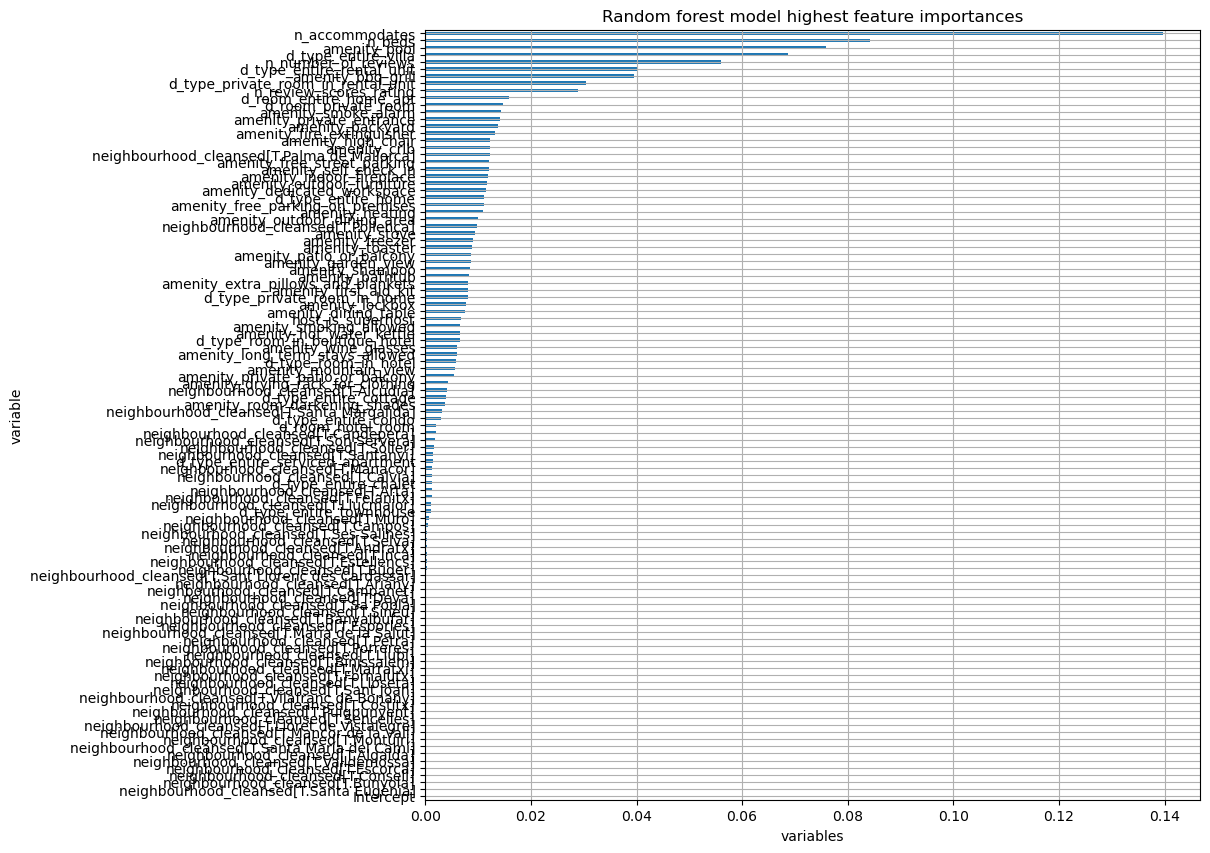

In [53]:
df_var_imp\
    .sort_values(by = 'imp')\
    .plot(kind = 'barh', 
          x = 'variable', y = 'imp', 
          figsize = (10,10), grid = True, 
          title = 'Random forest model highest feature importances', 
          xlabel = 'variables', legend = False
         );

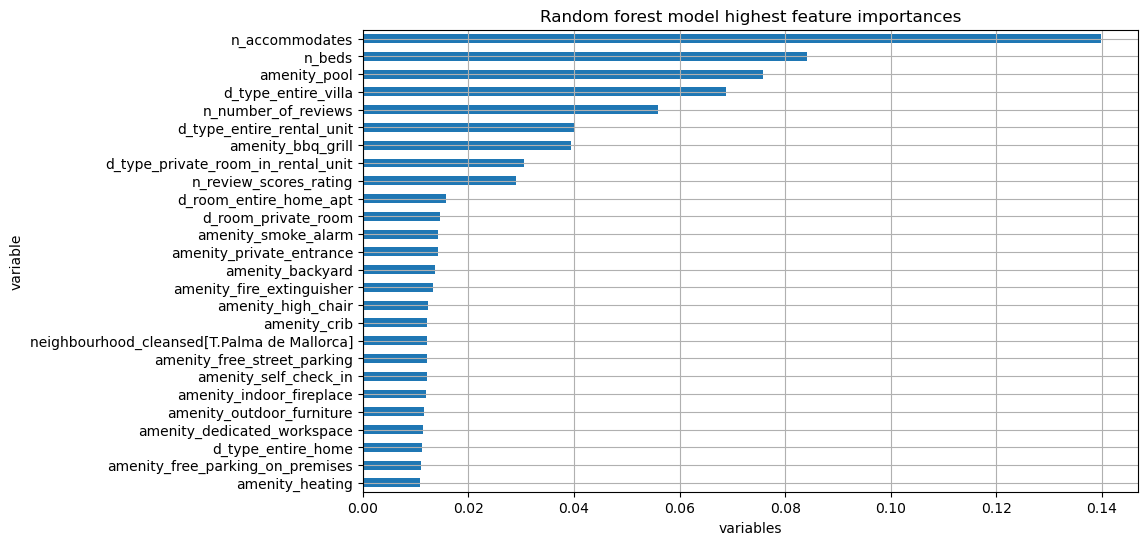

In [54]:
# we only care for variables with an importance of more than 1 pct
cutoff = 0.01

df_var_imp[df_var_imp.imp > cutoff]\
    .sort_values(by = 'imp')\
    .plot(kind = 'barh', 
          x = 'variable', y = 'imp', 
          figsize = (10,6), grid = True, 
          title = 'Random forest model highest feature importances', 
          xlabel = 'variables', legend = False
         );

#### 4.4.4 Grouped feature importances

In [55]:
categorical_encoder = OneHotEncoder(handle_unknown="ignore")

preprocessing = ColumnTransformer([
    ("cat", categorical_encoder, categorical_columns),
    ("num", "passthrough", numerical_columns)])

rf_pipeline = Pipeline(
    [("preprocess", preprocessing), 
     ("regressor", rf_model.best_estimator_)] # put best model to pipeline
)

In [56]:
%%time
rf_pipeline.fit(data_train[predictors_large],data_train.price)

CPU times: total: 1.53 s
Wall time: 1.51 s


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['neighbourhood_cleansed']),
                                                 ('num', 'passthrough',
                                                  ['n_accommodates', 'n_beds',
                                                   'host_is_superhost',
                                                   'd_type_entire_chalet',
                                                   'd_type_entire_condo',
                                                   'd_type_entire_cottage',
                                                   'd_type_entire_home',
                                                   'd_type_entire_rental_unit',
                                                   'd_type_entire_serviced_apar...
                                                   'n_review_scores_rating',
                                                   'amenity_bbq_grill',
                                                   'amenity_free_parking_on_premises',
                                                   'amenity_high_chair',
                                                   'amenity_heating',
                                                   'amenity_private_entrance',
                                                   'amenity_crib',
                                                   'amenity_freezer',
                                                   'amenity_stove',
                                                   'amenity_first_aid_kit',
                                                   'amenity_free_street_parking', ...])])),
                ('regressor',
                 RandomForestRegressor(max_features=12, min_samples_leaf=5,
                                       random_state=20240129))])

In [57]:
%%time
result = permutation_importance(
    rf_pipeline,
    data_holdout[predictors_large],
    data_holdout.price,
    n_repeats=10,
    random_state=45,
)

CPU times: total: 40.7 s
Wall time: 40.8 s


In [58]:
result

{'importances_mean': array([ 1.06076118e-01,  3.19605114e-02,  4.08524179e-03,  1.79642720e-02,
        -1.82525826e-05,  1.33662832e-03,  1.26197502e-03,  4.31317049e-03,
         2.95984165e-02,  6.60521544e-05,  1.66988118e-04,  5.33268523e-02,
         6.16723374e-03,  1.19545317e-02,  2.86259001e-03,  2.24617942e-03,
         6.12679054e-03,  6.14311105e-04,  6.39272208e-03,  1.87318048e-02,
         9.18671107e-03,  1.43959090e-02,  3.98457698e-03,  8.12621607e-03,
         3.71091167e-03,  8.94404449e-03,  9.61416829e-03,  5.00235153e-03,
         3.09130332e-03,  2.89406594e-03,  5.21007722e-03,  5.45591028e-03,
         4.31839133e-03,  7.83086498e-03,  3.90061945e-03,  1.37996750e-03,
         6.68730204e-03,  7.54947899e-03,  5.24038041e-02,  4.61881752e-03,
         7.21016285e-03,  6.48972733e-03,  3.40539678e-03,  1.78039128e-03,
         4.06699425e-03,  1.75490114e-03,  2.43376511e-03,  2.47978728e-03,
         1.44840419e-03,  1.09017048e-03,  8.20674842e-03,  4.651063

In [59]:
importances_df = pd.DataFrame(result.importances_mean, index=data_train[predictors_large].columns, columns=['Importance'])

importances_df = importances_df.sort_values(by='Importance', ascending=False)

importances_df

,Importance
n_accommodates,0.106076
d_type_entire_villa,0.053327
amenity_pool,0.052404
n_beds,0.031961
d_type_entire_rental_unit,0.029598
n_number_of_reviews,0.018732
neighbourhood_cleansed,0.017964
amenity_bbq_grill,0.014396
d_type_private_room_in_rental_unit,0.011955
amenity_crib,0.009614


#### 4.4.5 Grouped feature importance plots

In [60]:
df_clean_varimp = pd.DataFrame(
        result.importances_mean,
        data_train[predictors_large].columns)\
    .sort_values(by = 0, ascending = False)\
    .reset_index()\
    .rename({'index': 'variable', 0: 'imp'}, axis = 1)

df_clean_varimp['cumulative_imp'] = df_var_imp['imp'].cumsum()
df_clean_varimp[df_clean_varimp.cumulative_imp < 0.91]

,variable,imp,cumulative_imp
0,n_accommodates,0.106076,0.139774
1,d_type_entire_villa,0.053327,0.223952
2,amenity_pool,0.052404,0.299811
3,n_beds,0.031961,0.368573
4,d_type_entire_rental_unit,0.029598,0.424515
5,n_number_of_reviews,0.018732,0.464664
6,neighbourhood_cleansed,0.017964,0.504125
7,amenity_bbq_grill,0.014396,0.534583
8,d_type_private_room_in_rental_unit,0.011955,0.563514
9,amenity_crib,0.009614,0.579330


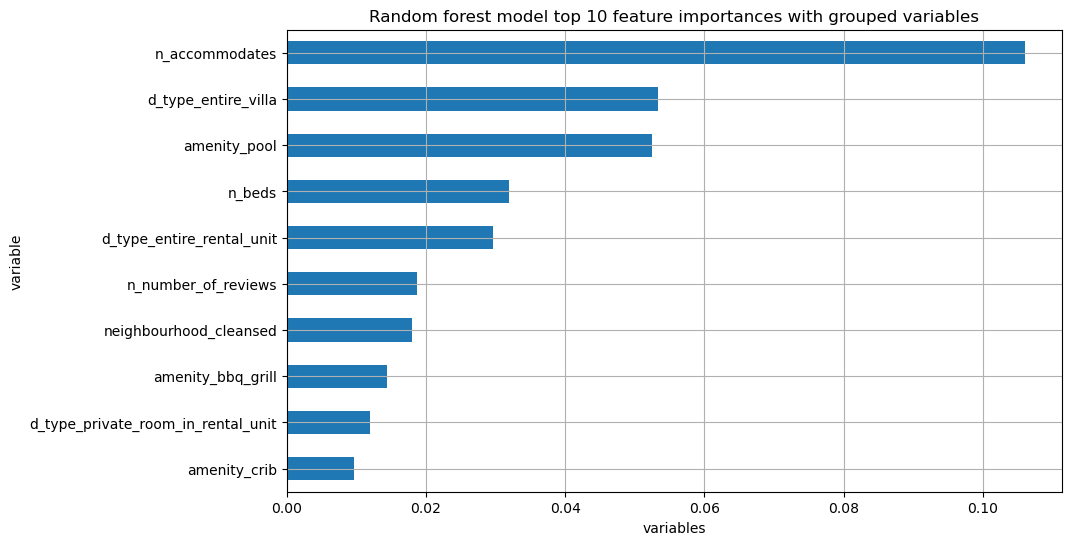

In [61]:
df_clean_varimp.iloc[0:10]\
    .sort_values(by = 'imp')\
    .plot(kind = 'barh', 
          x = 'variable', y = 'imp', 
          figsize = (10,6), grid = True, 
          title = 'Random forest model top 10 feature importances with grouped variables', 
          xlabel = 'variables', legend = False
         );

#### 4.4.6 Partial dependence plots

In [62]:
accomodates_pdp = partial_dependence(
    rf_pipeline, data_holdout[predictors_large], ["n_accommodates"], kind="average"
)

In [63]:
pd.DataFrame(
    {'number of accomodates': accomodates_pdp['values'][0], 
     'average price': accomodates_pdp['average'][0]}
    )

,number of accomodates,average price
0,2,172.842964
1,3,174.997226
2,4,184.345407
3,5,190.261499
4,6,213.779513


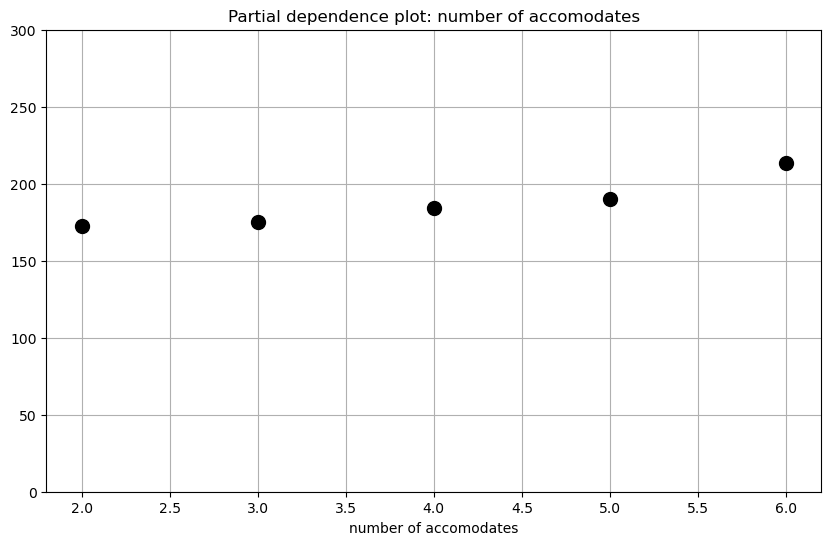

In [64]:
pd.DataFrame(
    {'number of accomodates': accomodates_pdp['values'][0], 
     'average price': accomodates_pdp['average'][0]}
    ).sort_values(by = 'average price').plot(
    kind = 'line', color = 'k', marker = 'o', markersize = 10, linewidth = 0,
    figsize = (10,6), legend = False, grid = True,
    x = 'number of accomodates', y = 'average price', ylim = (0, 300), 
    title = 'Partial dependence plot: number of accomodates'
);

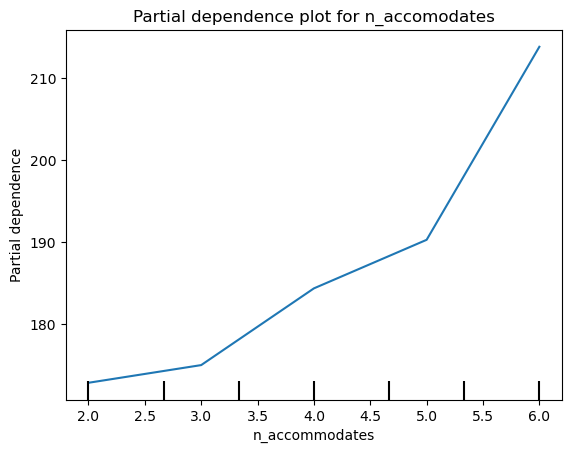

In [65]:
display = PartialDependenceDisplay(
    pd_results = [accomodates_pdp],
    features = [(0,)], 
    feature_names = data_holdout[predictors_large].columns.tolist(), 
    target_idx = 0,
    deciles = {0: np.linspace(2, 6, num=7)}
)
display.plot()
plt.title('Partial dependence plot for n_accomodates')
plt.show();

#### 4.4.7 Subsample performance

In [66]:
data_holdout_w_prediction = data_holdout.assign(
    predicted_price=rf_pipeline.predict(data_holdout[predictors_large])
)

In [67]:
data_holdout_w_prediction['is_low_size'] = data_holdout_w_prediction.n_accommodates.map(lambda x: 'small apt' if x < 3 else 'large apt')

In [68]:
data_holdout_w_prediction.iloc[0:10, -5:]

,d_room_hotel_room,d_room_private_room,n_accommodates_copy,predicted_price,is_low_size
8174,0,0,3,197.418513,large apt
8281,0,0,6,204.492709,large apt
188,0,0,6,234.777437,large apt
3310,0,0,6,234.570471,large apt
1303,0,0,6,233.116496,large apt
14995,0,0,2,111.763202,small apt
12473,0,0,6,269.008348,large apt
7667,0,0,4,166.933956,large apt
858,0,0,6,275.659322,large apt
15247,0,0,4,138.569737,large apt


In [69]:
data_holdout_w_prediction.groupby('is_low_size').apply(lambda x: mean_squared_error(x.predicted_price, x.price, squared=False))

is_low_size
large apt    70.059165
small apt    56.619734
dtype: float64

In [70]:
def calculate_rmse(groupby_obj):
    return (
        groupby_obj.apply(
            lambda x: mean_squared_error(x.predicted_price, x.price, squared=False),
        )
        .to_frame(name="rmse")
        .assign(mean_price=groupby_obj.apply(lambda x: np.mean(x.price)).values)
        .assign(rmse_norm=lambda x: x.rmse / x.mean_price).round(2)
    )

In [71]:
# cheaper or more expensive flats - not used in book
grouped_object = data_holdout_w_prediction.assign(
    is_low_size=lambda x: np.where(x.n_accommodates <= 3, "small apt", "large apt")
).groupby("is_low_size")
accom_subset = calculate_rmse(grouped_object)

In [72]:
accom_subset

,rmse,mean_price,rmse_norm
is_low_size,,,
large apt,71.19,211.24,0.34
small apt,55.00,129.43,0.42


#### 4.4.8 Get RMSE

In [73]:
all_holdout = pd.DataFrame(
    [
        mean_squared_error(
            data_holdout_w_prediction.price,
            data_holdout_w_prediction.predicted_price,
            squared=False,
        ),
        data_holdout_w_prediction.price.mean(),
    ],
    index=["rmse", "mean_price"],
).T.assign(rmse_norm=lambda x: x.rmse / x.mean_price).round(2)
all_holdout.index = ["Total"]

all_holdout

,rmse,mean_price,rmse_norm
Total,67.81,192.41,0.35


## 5. Performance Comparison (RMSE)

In [74]:
pd.DataFrame({'model': ['OLS', 'CART', 'random forest', 'GBM'],
              'CV RMSE': [ols_rmse, cart_rmse, all_holdout.rmse[0], gbm_rmse]})

,model,CV RMSE
0,OLS,70.256456
1,CART,79.473124
2,random forest,67.810000
3,GBM,65.012152
